In this notebook I will implement various Machine Learning Models and try to predict Earthquakes by analysing real world Earthquake data.
The dataset used in this notebook was obtained from [https://www.kaggle.com/usgs/earthquake-database](https://www.kaggle.com/usgs/earthquake-database)
The Dataset contains all significant earthquakes from 1965-2016.\\
N.B : Earthqaukes are classified as significant based on the magnitude, number of Did You Feel It responses, and PAGER alert level. \\
 I will be comparing the effectiveness of different Regression models on teh dataset to identify the model with the best performance. 
 Since I are using regression we will use the metrics $R^2$ score and explained variance regression score.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

ModuleNotFoundError: ignored

Upload the file dataset.csv here

In [ ]:
#from google.colab import files
#uploaded = files.upload()

The columns Date', 'Time', 'Latitude', 'Longitude', 'Depth' are selected as these are the only ones relevant for regression analysis. The rest have no effect on the predicted values.

In [ ]:
data = pd.read_csv(r"dataset.csv")
print(data.columns)
data.head()


Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [ ]:
data.isna().sum()
#data.describe()
#data.dropna()

Date                              0
Time                              0
Latitude                          0
Longitude                         0
Type                              0
Depth                             0
Depth Error                   18951
Depth Seismic Stations        16315
Magnitude                         0
Magnitude Type                    3
Magnitude Error               23085
Magnitude Seismic Stations    20848
Azimuthal Gap                 16113
Horizontal Distance           21808
Horizontal Error              22256
Root Mean Square               6060
ID                                0
Source                            0
Location Source                   0
Magnitude Source                  0
Status                            0
dtype: int64

In [ ]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [ ]:
data.describe()

,Latitude,Longitude,Depth,Magnitude
count,23412.000000,23412.000000,23412.000000,23412.000000
mean,1.679033,39.639961,70.767911,5.882531
std,30.113183,125.511959,122.651898,0.423066
min,-77.080000,-179.997000,-1.100000,5.500000
25%,-18.653000,-76.349750,14.522500,5.600000
50%,-3.568500,103.982000,33.000000,5.700000
75%,26.190750,145.026250,54.000000,6.000000
max,86.005000,179.998000,700.000000,9.100000


Detecting potential outliers using boxplot and z-score

<AxesSubplot:xlabel='Depth'>

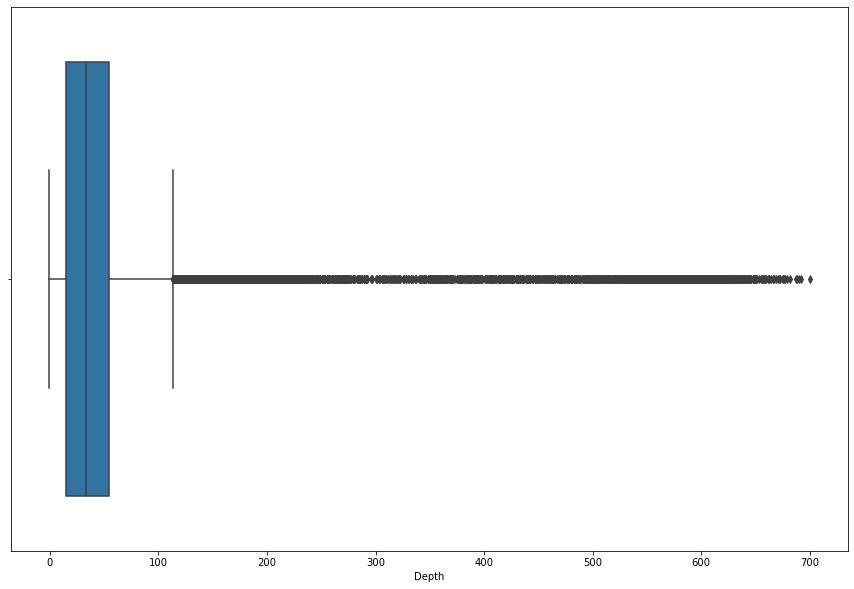

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x=data['Depth'])


<AxesSubplot:xlabel='Magnitude'>

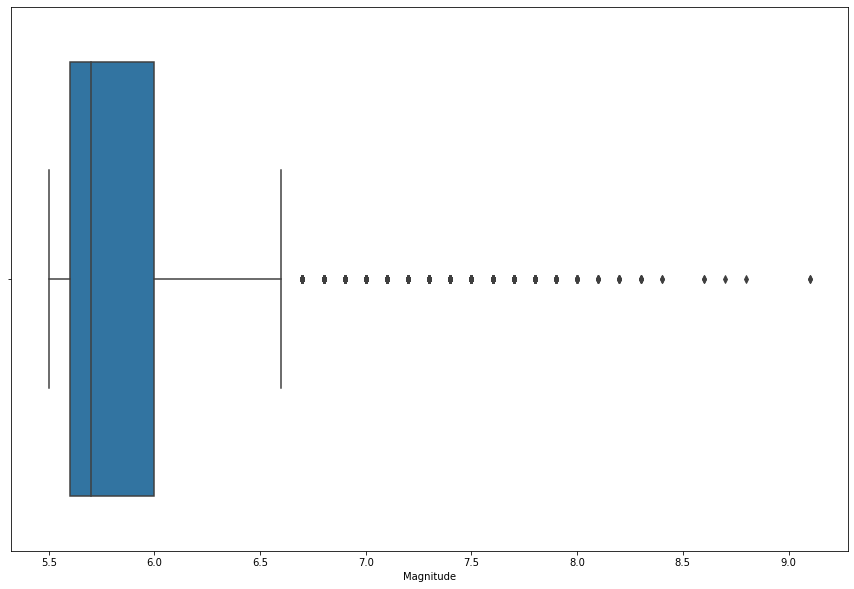

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x=data['Magnitude'])

In [ ]:
z_1 = np.abs(stats.zscore(data['Depth']))
z_2 = np.abs(stats.zscore(data['Magnitude']))
print("outliers for depth")
print(np.where(z_1 > 3))
print("outliers for Magnitude")
print(np.where(z_2 > 3))

outliers for depth
(array([    9,    13,    80, ..., 23350, 23364, 23394], dtype=int64),)
outliers for Magnitude
(array([   11,    16,    26,    87,   100,   103,   152,   165,   193,
         214,   217,   221,   227,   228,   242,   387,   518,   538,
         569,   571,   713,   771,   819,   823,   847,   858,   861,
         887,   911,   915,   939,   945,   996,  1004,  1006,  1013,
        1024,  1029,  1072,  1155,  1166,  1169,  1178,  1312,  1430,
        1431,  1448,  1463,  1543,  1576,  1606,  1621,  1625,  1634,
        1663,  1690,  1780,  1808,  1978,  1983,  2008,  2022,  2074,
        2158,  2175,  2213,  2229,  2241,  2271,  2295,  2299,  2342,
        2377,  2405,  2530,  2536,  2596,  2601,  2627,  2741,  2962,
        2969,  2985,  3159,  3164,  3196,  3253,  3256,  3279,  3290,
        3365,  3458,  3473,  3539,  3541,  3653,  3680,  3742,  3770,
        3819,  4028,  4029,  4047,  4164,  4293,  4309,  4310,  4318,
        4400,  4417,  4520,  4568,  4668,  473

In order to have a better understanding of the data let's generate some figure \\
Figure 1: A Histogram showing the number of occurencees of Earthquakes of varying magnitude. \\
Figure 2: Number of Significant Earthquakes every year since 1965 to 2016.

In [ ]:
data2 = data
data2['date']=data2['Date'].apply(lambda x: pd.to_datetime(x))
data2['year']=data2['date'].apply(lambda x:str(x).split('-')[0])


Text(0.5, 1.0, 'Earthquake Magnitude vs Number of Occurrences ')

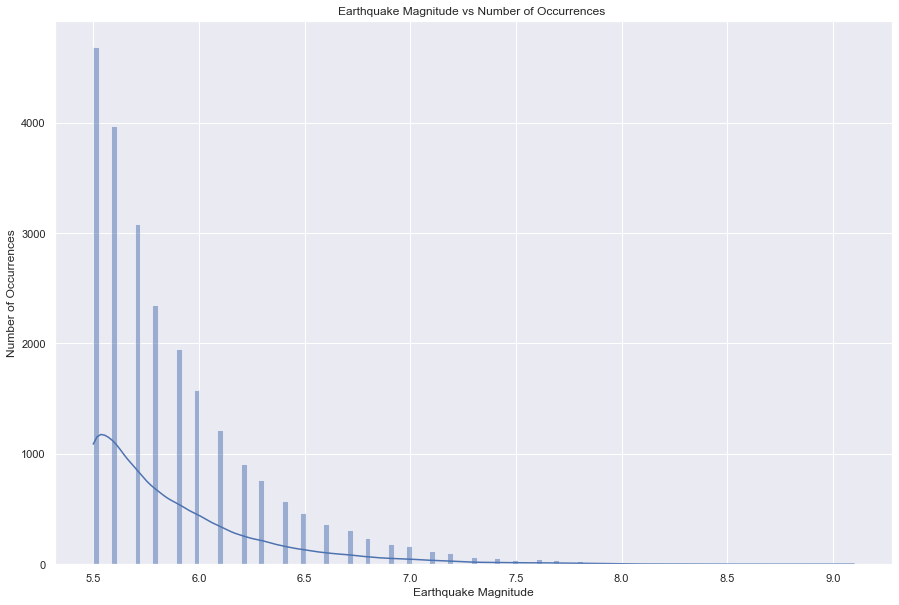

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=data2, x='Magnitude', kde=True)
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Number of Occurrences')
plt.title('Earthquake Magnitude vs Number of Occurrences ')

Text(0.5, 0, 'Number of Earthquakes in each year')

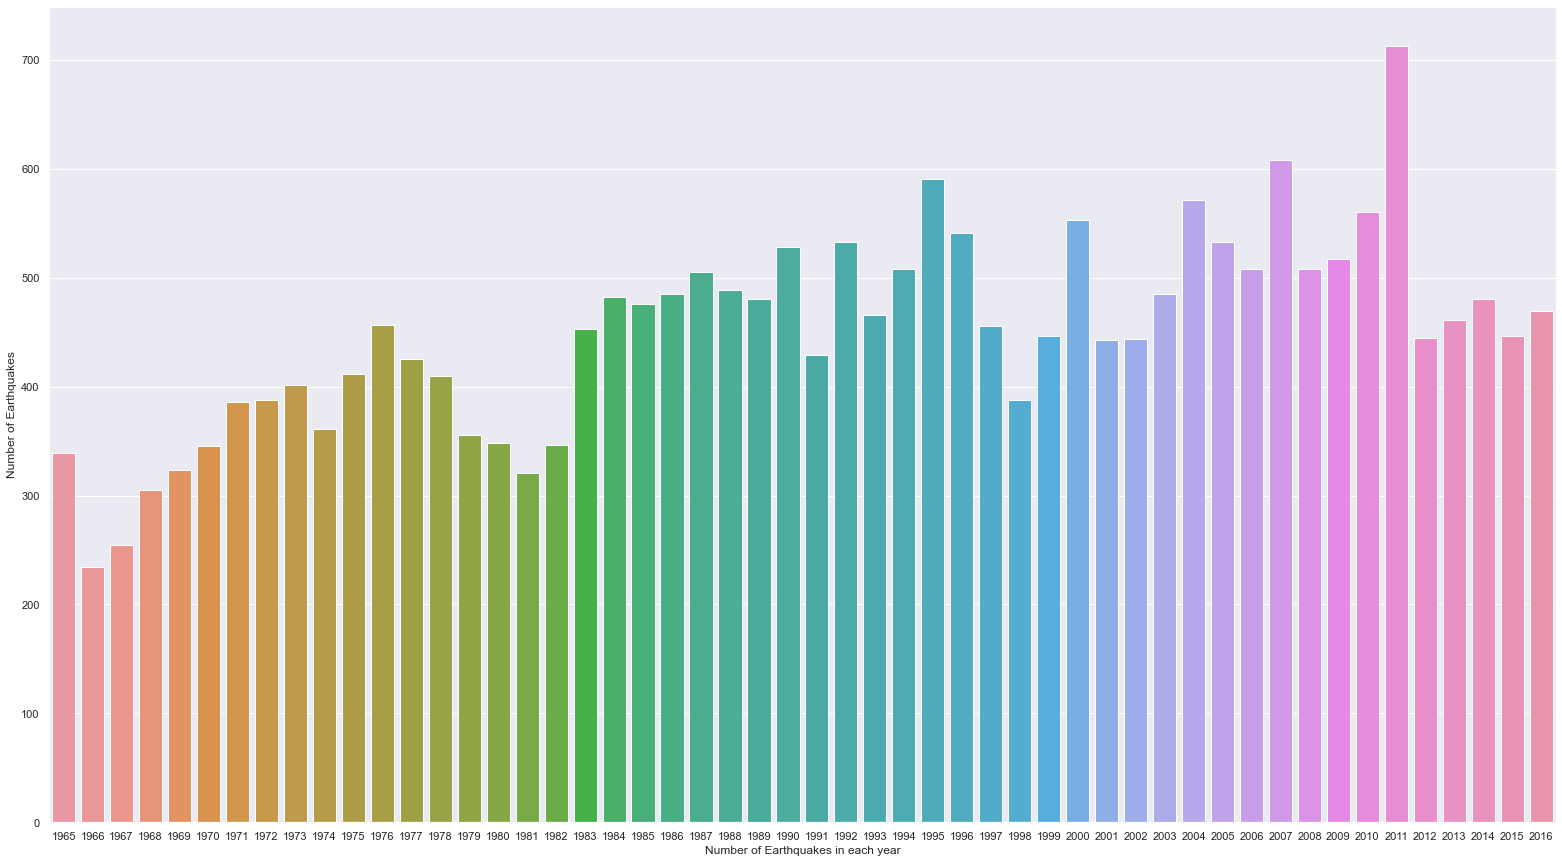

In [ ]:
plt.figure(figsize=(27,15))
sns.set(font_scale =1.0)
sns.countplot(x="year",data=data2)
plt.ylabel('Number of Earthquakes')
plt.xlabel('Number of Earthquakes in each year')

<Figure size 1944x1080 with 0 Axes>

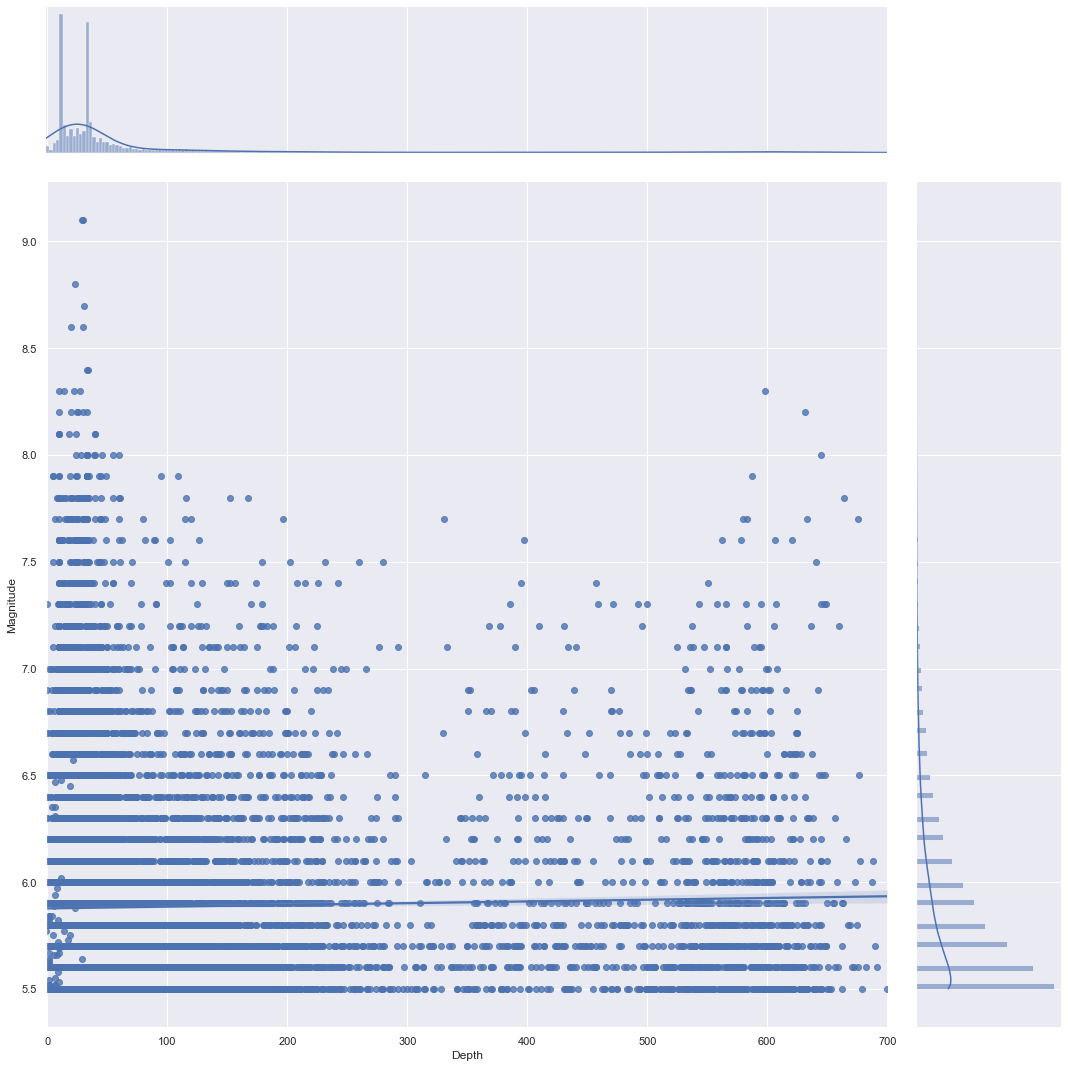

In [ ]:
plt.figure(figsize=(27,15))
sns.jointplot(data=data2, x="Depth", y="Magnitude", kind="reg", height=15)

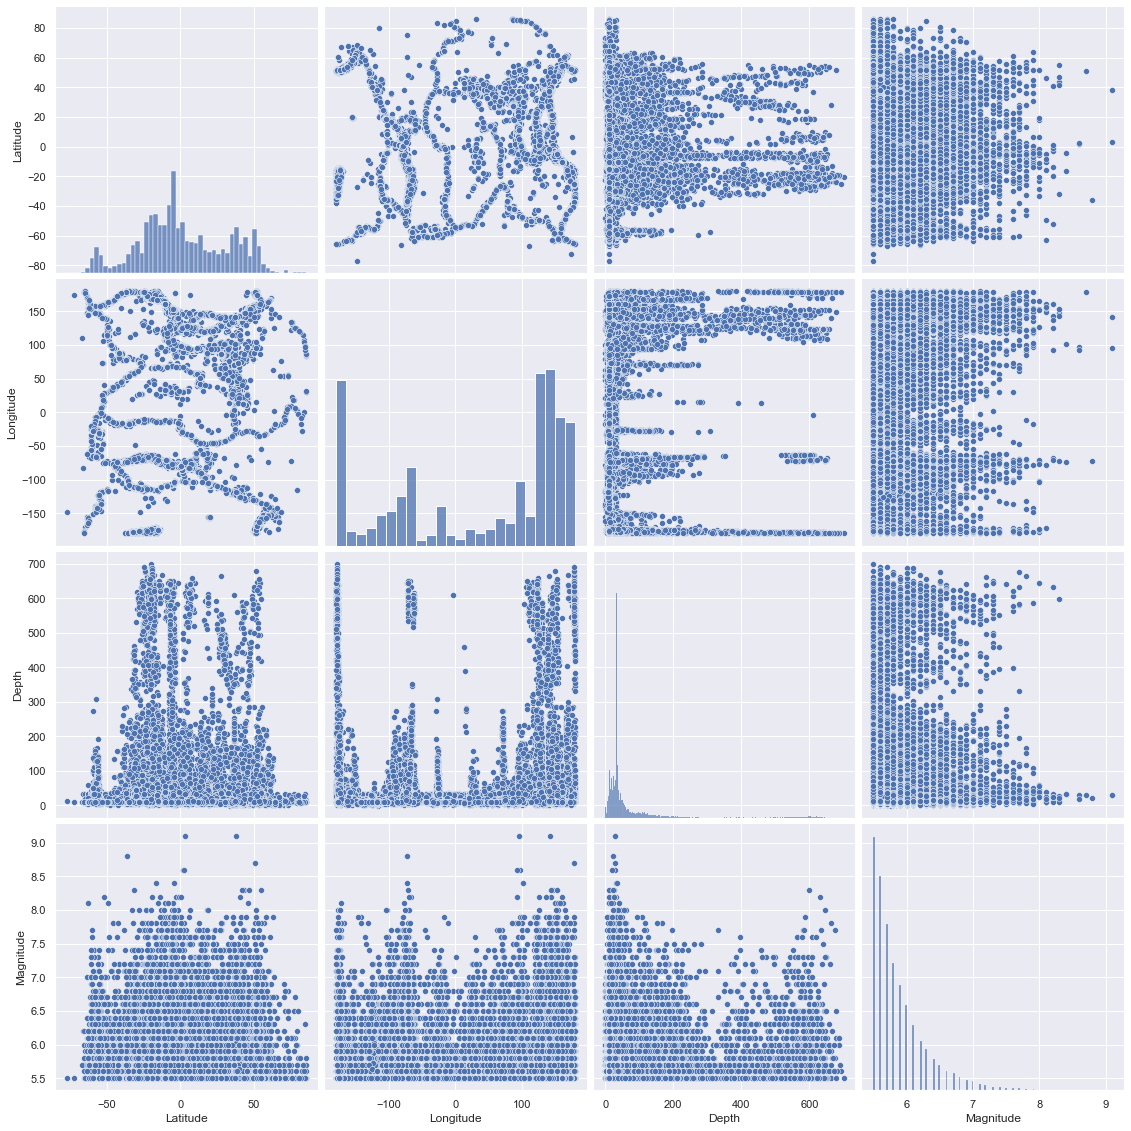

In [ ]:
sns.pairplot(data=data2, height=4)

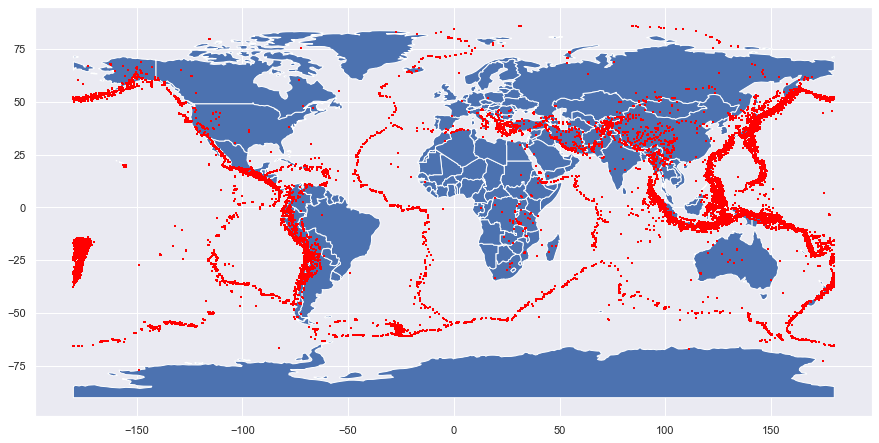

In [ ]:
geometry=[Point(xy) for xy in zip(data2["Longitude"], data2["Latitude"])]
gdf = gpd.GeoDataFrame(data2, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 10)), marker='+', color='red', markersize=5);

We will be performing time series analysis and the date and time are presented separately in the dataset. So I will convert the date and time to unix time (The unix time stamp is a way to track time as a running total of seconds). This make the time input easier to handle by the different models used in this notebook.

In [ ]:
final_data = data[['Latitude', 'Longitude', 'Depth', 'Magnitude']]

In [ ]:
timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        time_s = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(time_s.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()



OverflowError: mktime argument out of range

For the models input(X) will be Timestamp, Latitude and Longitude and Output (y)will be Magnitude and Depth. Split the Xs and ys into train and test with validation. Training dataset contains 80% and Testing dataset contains 20%.

In [ ]:
X = final_data[[ 'Latitude', 'Longitude']]
y = final_data[['Magnitude','Depth']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18729, 2) (4683, 2) (18729, 2) (4683, 2)


The Random Forest Regressor performs as expected. I changed the multioutput method to variance weighted as this produces better results when compared to uniform weighted. I will also use GridSearchCV to see if the performance of the model can be further improved by finetuning the hyperparameters which in this case will the number of trees(n_estimators). [Note : Default value is 100]

In [ ]:
#Random Forest 
rf = RandomForestRegressor(random_state=10)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

Random Forest Model \\
Evaluation using $R^2$ score, explained variance regression score, mean absolute error regression loss, and mean squared error regression loss


In [ ]:
# View R2 score
print(r2_score(y_test, rf_pred, multioutput='raw_values'))
# View explained variance regression score
print(explained_variance_score(y_test, rf_pred, multioutput='raw_values'))
# View Mean absolute error regression loss
print(mean_absolute_error(y_test, rf_pred, multioutput='raw_values'))
# View Mean squared error regression loss
print(mean_squared_error(y_test, rf_pred, multioutput='raw_values'))
rf.get_params

[-0.12377681  0.85790651]
[-0.12376932  0.85791277]
[ 0.32974234 20.28635382]
[2.06061844e-01 2.05431786e+03]


<bound method BaseEstimator.get_params of RandomForestRegressor(random_state=10)>

In [ ]:
mul_val_scorer = make_scorer(r2_score, multioutput='variance_weighted')
#parameters = {'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
parameters = {'n_estimators':[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]}
#Since the best estimator came out to be x we will use that to shorten computation time
#parameters = {'n_estimators':[10, 20, 50, 100, 200, 250, 500, 1000]}
grid_rf = GridSearchCV(rf, parameters, scoring = mul_val_scorer)
grid_rf.fit(X_train, y_train)
rf_pred_2=grid_rf.predict(X_test)
grid_rf.cv_results_

{'mean_fit_time': array([0.31001239, 0.61889782, 0.92402687, 1.23689909, 1.55281701,
        1.85951967, 2.18337345, 2.48911619, 2.78184538, 3.08291149,
        3.4483367 , 3.70286541, 4.00586696, 4.32947693, 4.62748122,
        4.94386148, 5.29059849, 5.554216  , 5.92672677, 6.14463863]),
 'std_fit_time': array([0.00632931, 0.00740785, 0.01164645, 0.01191511, 0.01053243,
        0.02399829, 0.00632315, 0.02002274, 0.02309098, 0.01067039,
        0.05357241, 0.02488461, 0.01347711, 0.01409398, 0.01167562,
        0.02033839, 0.04638682, 0.04934836, 0.09087555, 0.05479298]),
 'mean_score_time': array([0.01180696, 0.02023387, 0.0308445 , 0.03882389, 0.04754839,
        0.05466161, 0.06125174, 0.07677765, 0.0795135 , 0.09143109,
        0.09593997, 0.11269741, 0.11921644, 0.12572913, 0.12698326,
        0.14310222, 0.14614725, 0.15822334, 0.1713932 , 0.17283716]),
 'std_score_time': array([0.00622823, 0.00676212, 0.00092254, 0.00933027, 0.00132926,
        0.00707796, 0.00323976, 0.004161

Modified Random Forest Model with optimal parameters \\
Evaluation using $R^2$ score, explained variance regression score, mean absolute error regression loss, and mean squared error regression loss

In [ ]:
# View R2 score
print(r2_score(y_test, rf_pred_2, multioutput='raw_values'))
# View explained variance regression score
print(explained_variance_score(y_test, rf_pred_2, multioutput='raw_values'))
# View Mean absolute error regression loss
print(mean_absolute_error(y_test, rf_pred_2, multioutput='raw_values'))
# View Mean squared error regression loss
print(mean_squared_error(y_test, rf_pred_2, multioutput='raw_values'))
grid_rf.best_estimator_
grid_rf.best_params_

[-0.12070949  0.85743122]
[-0.1207069   0.85743714]
[ 0.32926419 20.31476203]
[2.05499403e-01 2.06118941e+03]


{'n_estimators': 120}

In order to check just how effective Random Forest is in this scenario I decided to implement Linear and Polynomial Regression. Unsurprisingly the results cannot be compared to Random forest which is significantly better. 

In [ ]:
Xp = final_data[['Latitude','Longitude']]
yp = final_data[['Depth','Magnitude']]
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.1, random_state=10)
print(Xp_train.shape, Xp_test.shape, yp_train.shape, yp_test.shape)

(21070, 2) (2342, 2) (21070, 2) (2342, 2)


In [ ]:
#Linear Regression 
lin_reg = LinearRegression()
lin_reg.fit(Xp_train,yp_train)
lin_pred = lin_reg.predict(Xp_test)
#Polynomial Regression
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Xp_train)
X_poly_test = poly_reg.fit_transform(Xp_test)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, yp_train)
poly_pred = pol_reg.predict(X_poly_test)

In [ ]:
#Metrics for Linear and Polynomial Regression
print(r2_score(yp_test,lin_pred , multioutput='raw_values'))
print(r2_score(yp_test,poly_pred , multioutput='raw_values'))

0.005495
0.074792
